In [150]:
## Libraries
import glob
from multiprocessing import cpu_count
import os
import random
import sys

## 3rd party
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image, ImageFilter
import torch
from torch.utils.data import DataLoader

_path = ".."
if _path not in sys.path:
    sys.path.append(_path)
from lib.dataset import TextArtDataLoader, AlignCollate, ImageBatchSampler
from lib.config import Config
# from lib.preprocess import (pad_image, crop_edges_lr, )

%reload_ext autoreload
%autoreload 2

In [174]:
BATCH_SIZE = 4
# N_WORKERS = cpu_count() - 1
N_WORKERS = 0
CONFIG = Config()

In [175]:
train_dataset = TextArtDataLoader('united', CONFIG.WORD2VEC_MODEL_FILE, mode='train')
val_dataset = TextArtDataLoader('united', CONFIG.WORD2VEC_MODEL_FILE, mode='val')
test_dataset = TextArtDataLoader('united', CONFIG.WORD2VEC_MODEL_FILE, mode='test')
train_align_collate = AlignCollate('train',
                                   CONFIG.WORD2VEC_MODEL_FILE,
                                   CONFIG.MEAN,
                                   CONFIG.STD,
                                   CONFIG.IMAGE_SIZE_HEIGHT,
                                   CONFIG.IMAGE_SIZE_WIDTH,
                                   horizontal_flipping=CONFIG.HORIZONTAL_FLIPPING,
                                   random_rotation=CONFIG.RANDOM_ROTATION,
                                   color_jittering=CONFIG.COLOR_JITTERING,
                                   random_grayscale=CONFIG.RANDOM_GRAYSCALE,
                                   random_channel_swapping=CONFIG.RANDOM_CHANNEL_SWAPPING,
                                   random_gamma=CONFIG.RANDOM_GAMMA,
                                   random_resolution=CONFIG.RANDOM_RESOLUTION,
                                   word_padding_similars_topN=CONFIG.WORD_PADDING_SIMILARS_TOPN)
val_align_collate = AlignCollate('val',
                                 CONFIG.WORD2VEC_MODEL_FILE,
                                 CONFIG.MEAN,
                                 CONFIG.STD,
                                 CONFIG.IMAGE_SIZE_HEIGHT,
                                 CONFIG.IMAGE_SIZE_WIDTH,
                                 horizontal_flipping=CONFIG.HORIZONTAL_FLIPPING,
                                 random_rotation=CONFIG.RANDOM_ROTATION,
                                 color_jittering=CONFIG.COLOR_JITTERING,
                                 random_grayscale=CONFIG.RANDOM_GRAYSCALE,
                                 random_channel_swapping=CONFIG.RANDOM_CHANNEL_SWAPPING,
                                 random_gamma=CONFIG.RANDOM_GAMMA,
                                 random_resolution=CONFIG.RANDOM_RESOLUTION,
                                 word_padding_similars_topN=CONFIG.WORD_PADDING_SIMILARS_TOPN)

batch_sampler = ImageBatchSampler('united', BATCH_SIZE, shuffle_groups=True)

train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=N_WORKERS,
                          pin_memory=True,
                          collate_fn=train_align_collate,
                          sampler=batch_sampler,
                         )
val_loader = DataLoader(val_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=N_WORKERS,
                          pin_memory=True,
                          collate_fn=val_align_collate,
                         )
test_loader = DataLoader(test_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=N_WORKERS,
                          pin_memory=True,
                          collate_fn=None,
                         )

IMAGE: torch.Size([4, 3, 196, 256])
WV: torch.Size([4, 10, 2000])


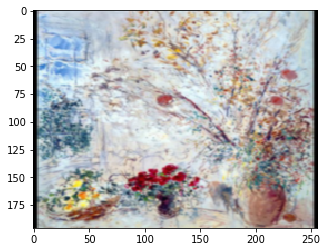

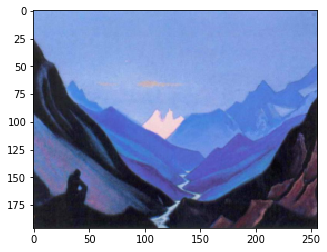

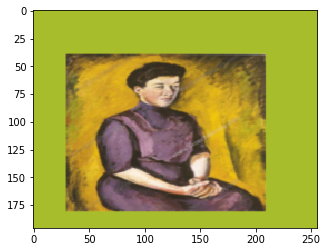

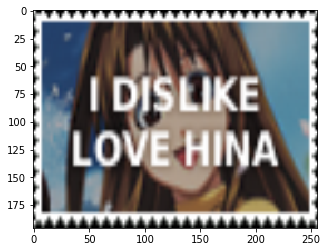

In [195]:
random_batch_i = np.random.randint(1)
for i, (image, word_vectors_tensor) in enumerate(train_loader):
    if i < random_batch_i:
        continue
#     print(label_sentence, image_file)
    print("IMAGE:", image.shape)
    print("WV:", word_vectors_tensor.shape)
    images = np.array(image)
#     print(word_vectors_tensor)
    for img in images:
        img = img.transpose(1, 2, 0)
        plt.imshow(img)
        plt.show()
    break

In [38]:
mod = train_dataset.word2vec_model

In [183]:
vector

array([-0.20759055,  0.14224935,  0.11896729, ...,  0.03228494,
        0.15717718, -0.12497474], dtype=float32)

In [181]:
mod.wv.similar_by_vector(vector, topn=20)

[('cat', 1.0),
 ('kitty', 0.8099162578582764),
 ('birch', 0.7829535603523254),
 ('feline', 0.7758954763412476),
 ('kitten', 0.7281227707862854),
 ('willow', 0.7227879762649536),
 ('medicine', 0.7053609490394592),
 ('clan', 0.7051528692245483),
 ('thunderclan', 0.6813822984695435),
 ('firestar', 0.6610948443412781),
 ('wc', 0.6576641798019409),
 ('janice', 0.6509424448013306),
 ('fursona', 0.6463249921798706),
 ('fuzzy', 0.6454205513000488),
 ('jayfeather', 0.6451109051704407),
 ('crooked', 0.6444038152694702),
 ('pelt', 0.6395221948623657),
 ('bramble', 0.6300094127655029),
 ('erin', 0.6219429969787598),
 ('paw', 0.609721302986145)]

In [166]:
vector1 = mod.wv['cat']
vector2 = mod.wv['dog']
a = np.stack((vector1, vector2))

In [168]:
random.choice(a)

array([-0.05532061,  0.06599543, -0.03499441, ..., -0.22259007,
        0.13914508,  0.09098542], dtype=float32)

In [147]:
similar_words = np.array(mod.wv.similar_by_vector(vector, topn=20))
np.random.choice(similar_words[:,0], 3, replace=False)

array(['erin', 'fuzzy', 'firestar'], dtype='<U18')

In [ ]:
img = np.array(image)[1].transpose(1, 2, 0)

In [ ]:
plt.imshow(img)

In [ ]:
np.all(img <= 1.0)

In [ ]:
np.all(img >= -1.0)

In [ ]:
img

In [57]:
batch_sampler = ImageBatchSampler('united', BATCH_SIZE)

In [ ]:
df = batch_sampler.df

In [ ]:
## Group batches
df_n_labels_grouped = df.groupby(by=pd.cut(df['n_labels'], [0, 5, 7, 11, 1000]))
for key1, item1 in df_n_labels_grouped:
    print("\nN LABEL GROUP", key1)
    df1 = df_n_labels_grouped.get_group(key1)
    df_width_grouped = df1.groupby(by=pd.cut(df1['width'], [0, 500, 700, 1000, 10000]))
    for key2, item2 in df_width_grouped:
        print("\tWIDTH GROUP", key2)
        df2 = df_width_grouped.get_group(key2)
        df_height_grouped = df2.groupby(by=pd.cut(df2['height'], [0, 590, 10000]))
        for key3, item3 in df_height_grouped:
            print("\t\tHEIGHT GROUP", key3)
#             print(df_height_grouped.get_group(key3), "\n\n")
            print('\t\t\t', len(df_height_grouped.get_group(key3).index), 'samples')

In [ ]:
df[df['index'].isin(batches[index])]

In [ ]:
len(train_dataset)

In [158]:
vector.shape

(2000,)